# Heart Disease Prediction - Modeling

In this notebook, we will explore a dataset containing clinical information about healthy patients and those with heart disease. We will perform feature engineering and selection, and then train and evaluate several machine learning models to predict whether a patient has heart disease.


## Big Picture
- **Goal**: Predict whether a patient has heart disease or not
- **Uses cases (patients and hcp)**:
    - Improve quality of health services-- enable healthcare providers to diagnose patients with heart disease early and adminstering effective treatments. Reduce unnecessary treatments/tests for patients who are unlikely to have heart disease.
    - Identify the most important factors associated with heart disease. Remove tests/measurements that are not predictive to reduce patients' costs and time.
- **Use cases (marketing team)**:
    - Serve as a proof-of-concept: can we predict heart disease with clinical data that are obtainable from pathology labs and health care providers? If so, can we partner with these entities to obtain more data?
    - With more data, we may train a model to generate mean predicted probabilities of heart disease in a geographic area (e.g., HSA or census tract). This allow us to gauge the demand for Pfizer's products such as Vyndaqel and Vyndamax in specific geographic areas, which in turn inform the company's production and distribution plans, as well as marketing strategies at a more precise level.
    - Can we profile people who are most likely to have heart disease (do they have specific sociodemographic characterisitics? Do they get their health information from certain sources-- social media, blogs, doctors, friends and family)-- this allow us to target these patients  with more relevant marketing messages. 


In [1]:
'''common'''
import pandas as pd
import numpy as np
import math
from collections import OrderedDict
import scipy.stats as stats
from pathlib import Path
from functools import partial
import pickle

'''visualization'''
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 14
plt.rcParams["patch.edgecolor"]= "k"

import seaborn as sns


'''sklearn'''
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Binarizer, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier

'''metrics'''
from sklearn.metrics import (
    confusion_matrix,
    precision_score, recall_score, f1_score, classification_report,
    roc_curve, roc_auc_score
)


'''feature-engine'''
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.transformation import LogCpTransformer

'''hyperopt'''
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample


'''pandas options'''
# display maximum of 150 columns in a pandas dataframe
pd.options.display.max_columns = 150


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Custom modules
import src.data_manager as dm
import src.utils as utils
import src.features as ft

In [3]:
# Reload modules
%load_ext autoreload
%autoreload 2

### Config

In [4]:
# Number of k-folds for cross-validation
N_FOLDS = 5 
# Random seed for reproducibility
RANDOM_STATE = 42
# test size
TEST_SIZE = 0.2
# number of iterations
N_ITER = 100

## Import data

In [5]:
df = dm.load_data(Path("data","heart_preprocessed.csv")) 
df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Feature engineering
- We will perform the following feature engineering steps (doesn't need to be perfect, just want something reasonable):
- Categorical variables:
    - Impute all missing values with mode
    - `cp` lump the two angina chest pains into a single level
    - `restecg` lump the two atypical conditions into a single level (so we have normal and abnormal)
    - `thal` lump the two defect conditions into a single level (so we have normal and defect)
    - `ca` binarize this variable: lump all non-zero values into a single level
    - One hot encode all categorical variables
- Numeric variables:
    - Impute all missing values with mean
    - `oldpeak` is highly skewed, transform it
    - Standardize all numeric variables (while tree-based algorithms don't require standardization, logisitic regression with regularization does)


### Variable mappings

In [6]:
# For cp, recode atypical angina and typical angina as angina
CP_MAPPINGS = {"atypical angina": "angina", "typical angina": "angina", "non-anginal":"non_anginal"}
# For restecg, recode having ST-T wave abnormality and left ventricular hypertrophy as abnormal
RESTECG_MAPPINGS = {"lv hypertrophy": "abnormal", "st-t abnormality": "abnormal"}
# For thal, recode fixed defect and reversable defect as defect
THAL_MAPPINGS = {"fixed defect": "defect", "reversable defect": "defect"}

In [7]:
# Cast "ca" as object
df["ca"] = df["ca"].astype("object")

In [8]:
### Get categorical and numerical columns
cat_cols, num_cols = utils.get_num_cat_vars(df)

# Remove id and target
num_cols = [c for c in num_cols if (c != "id") & (c!="target")]


### Test train split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['id', 'target'], axis=1), # predictive variables
    df['target'], # target
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
)

X_train.shape, X_test.shape

((243, 13), (61, 13))

### Data Pipeline

In [10]:
# Categorical variables pipeline
cat_pipeline = Pipeline([
    ('cat_imputer', CategoricalImputer(imputation_method='frequent', variables=cat_cols)),
    ('mapper_cp', ft.Mapper(variables=["cp"], mappings=CP_MAPPINGS)),
    ('mapper_restecg', ft.Mapper(variables=["restecg"], mappings=RESTECG_MAPPINGS)),
    ('mapper_thal', ft.Mapper(variables=["thal"], mappings=THAL_MAPPINGS)),
    ('binarizer', SklearnTransformerWrapper(transformer = Binarizer(threshold=0),
                                           variables =["ca"])),
    ('one_hot_encoder', SklearnTransformerWrapper(OneHotEncoder(drop='first', sparse_output=False), variables = cat_cols)) 
])

In [11]:
# Numeric variables pipeline
num_pipeline = Pipeline([
    ('num_imputer', MeanMedianImputer(imputation_method='median', variables=num_cols)),
    ('log_transformer', LogCpTransformer(variables = ["oldpeak"], C="auto")),
    ('scaler', SklearnTransformerWrapper(StandardScaler(), variables=num_cols))    
])

## Modeling
- Train a baseline model, and then train several other models using different statistical learning approach, and compare their performance (measured using CV scores e.g., roc_auc)
- I will not tune the hyperparameters for the time being. Once I select the most appropiate statistical learning approach, then I will optimize the model using hyperopt.
- I will evaluate the optimized model using the test set.

We will try the following models with default hyperparameters-- they are chosen for their interpretability, speed, and performance on small datasets
- Baseline model: dummy classifier
- Logistic regression with regularization
- Decision Tree
- LightGBM

In [12]:
# define models to test
def get_models():
    # init list of models with associated names
    models,names = list(), list()
    
    # dummy
    models.append(DummyClassifier())
    names.append("dummy")
    
    # linear regression
    models.append(LogisticRegression(random_state=RANDOM_STATE))
    names.append("logistic_regression")
    
    # Decision tree
    models.append(DecisionTreeClassifier(random_state=RANDOM_STATE))
    names.append("decision_tree")
    
    # Gradient Boosted Trees
    models.append(GradientBoostingClassifier(random_state=RANDOM_STATE))
    names.append("gbm")
    
    return models, names

In [13]:
# Evaluate a model with k-fold cross validation (default CV scheme if I specify a number for the cv parameter below)
def evaluate_model(X,y,pipeline):
    scores = cross_val_score(
        estimator = pipeline,
        X = X,
        y = y,
        cv = N_FOLDS,
        scoring = "roc_auc",
        n_jobs=-1)
    
    return scores

### Model selection: evaluate each model using CV

In [14]:
models, names = get_models()

In [15]:
# Evaluate each model (get estimated test metric) and store the results in a list "l_mean_cv_scores"
l_cv_scores = list()
for model, name in list(zip(models, names)):
    
    # Data pipeline
    pipeline = Pipeline([("cat_pipeline", cat_pipeline), 
                         ("num_pipeline", num_pipeline),
                         ("model", model)
                         ])
    
    # Compute cv scores of each model
    cv_scores = evaluate_model(X_train, y_train, pipeline)
    
    # Update the list of model results, each row represent the cv scores of a model
    l_cv_scores.append(cv_scores)

    # Summary of model performance
    print((name, round(cv_scores.mean(),2), round(np.std(cv_scores),2)))

('dummy', 0.5, 0.0)
('logistic_regression', 0.91, 0.02)
('decision_tree', 0.71, 0.04)
('gbm', 0.86, 0.03)


Text(0, 0.5, 'roc_auc')

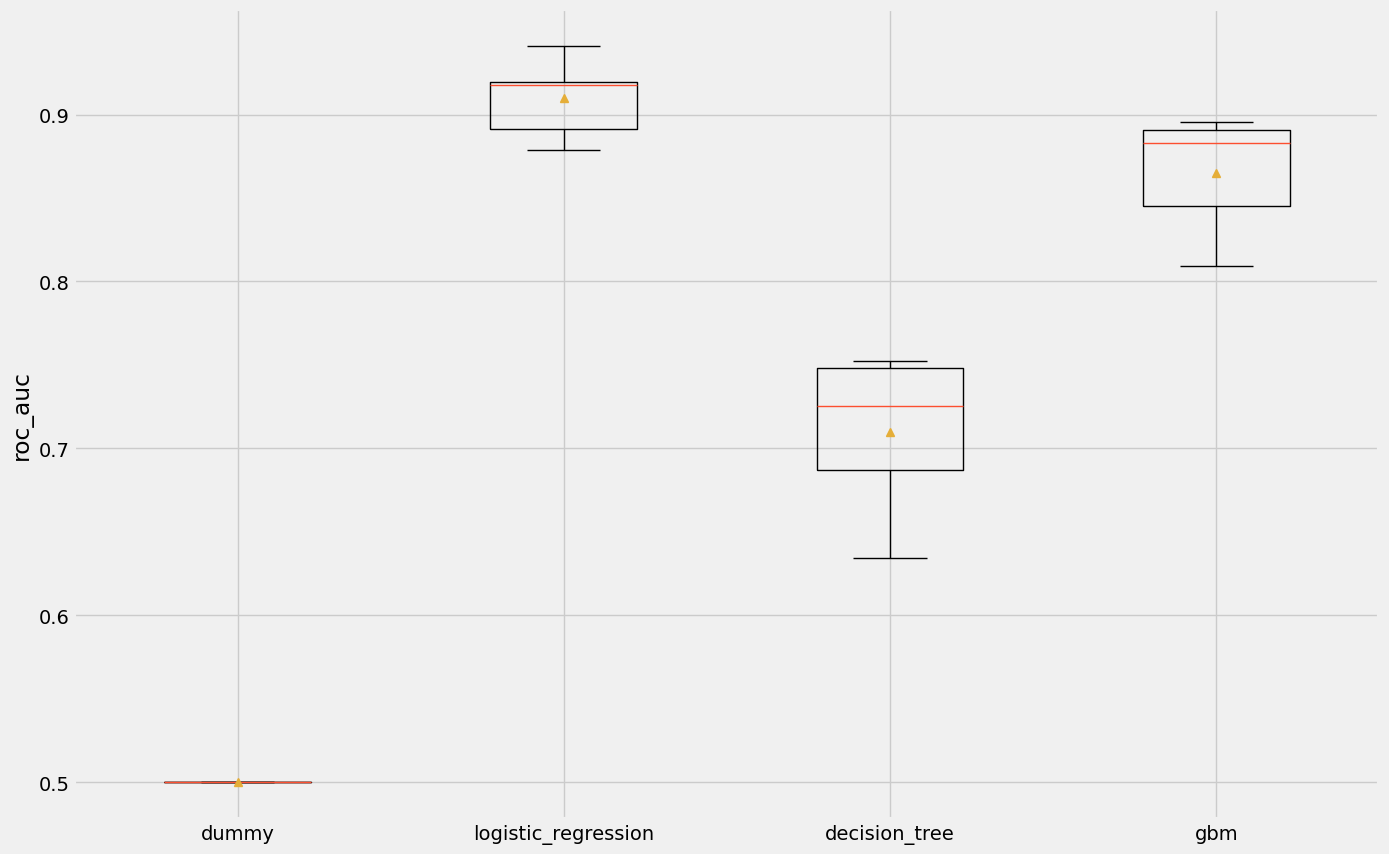

In [16]:
fig = plt.figure(figsize=(15,10))
plt.boxplot(l_cv_scores, labels=names, showmeans=True)
plt.ylabel("roc_auc")

### Comments:
- The roc_auc for the dummy classifier is 0.5, which is expected since it's a random guess.
- The model with the best performance is logistic regression. It's also fast to train, has the least hyperparameters to tune, and the easiest to interpret. This result also indicates that the predictors are linearly associated with the outcome.
- We will select logsitic regression and fine tune it using hyperopt.

### Hyperparameter tuning
- I will tune the penalty term `C` for logistic regression
- I will set teh model to use L1 (Lasso) regularization-- the coefficients of the predictors that are not important will be shrunk to zero. This will allow us to identify the most important predictors and develop a parsimonious model.

**Create the optimization function**

In [17]:
def optimize(params,X,y):
    """optimize
    Args:
        Params(Dict): hyperparameters to optimize, key-value pairs
        X(pd.DataFrame): training data
        y(pd.Series): training target
    Returns:
        (float): mean cv scores
    """
    
    model = LogisticRegression(**params, penalty="l1", solver= "liblinear", random_state=RANDOM_STATE)
    
    pipeline = Pipeline([("cat_pipeline", cat_pipeline), 
                         ("num_pipeline", num_pipeline),
                         ("model", model)
                         ])
    
    # Compute CV scores
    cv_scores = cross_val_score(
        estimator = pipeline,
        X = X,
        y = y,
        cv = N_FOLDS,
        scoring = "neg_log_loss",
        n_jobs=-1)
    
    # neg_log_loss is a utilitiy value that allows some optimization function 
    # to maximize it. It is "higher the better". Hyperopt expects me to have a loss function
    # So I need to negate "neg_log_loss" to have the regular log_loss metric
    
    return {
        'loss': -1.0*cv_scores.mean(), 
        'std': cv_scores.std(), 
        'status': STATUS_OK
    }


**Define the hyperparmaeter space**

In [18]:
param_space = {
    "C" : hp.uniform("C", 0.01, 10)
}

In [19]:
sample(param_space)

{'C': 6.664400855516444}

In [20]:
# Create a partial function, we preset X and y with the train data
optim_func = partial(optimize,X=X_train, y=y_train)

**Call the fmin() function from hyperopt to optimize the hyperparameters**

- fmin() requires the objective function, param_space, and other settings.
- All values of the hyperparameters and scores for each iteration (trials) are stored in the Trials object

In [21]:
trials = Trials()

result = fmin(
    fn=optim_func,
    space=param_space,
    algo=tpe.suggest,
    max_evals=N_ITER,
    trials=trials 
)

100%|██████████| 100/100 [00:09<00:00, 10.31trial/s, best loss: 0.38091062337287535]


In [22]:
# Optimized parameters
space_eval(param_space, result)

{'C': 1.4951411950972922}

## Evaluating the optimized model

In [23]:

best_clf = LogisticRegression(**space_eval(param_space, result), 
                              penalty="l1", 
                              solver= "liblinear", 
                              random_state=RANDOM_STATE)

best_pipeline = Pipeline([("cat_pipeline", cat_pipeline),
                            ("num_pipeline", num_pipeline),
                            ("save_col_names", ft.save_col_names()),
                            ("model", best_clf)
                             ])

# Persist the best_pipeline as a pickle file
dm.save_pipeline(best_pipeline, file_path=Path("models","optimized_logreg.pkl"))

### Feature importance in odds-ratio

In [24]:
# Compute the odds-ratio of each feature
best_pipeline.fit(X_train, y_train)
# Get regression coefficients values
coef_vals = np.exp(best_pipeline.steps[3][1].coef_)
# Read column names from pickle file
with open(Path("outputs","processed_col_names.pkl"),'rb') as f:
    col_names=pickle.load(f).to_list()
    
# Create a dataframe with the odds-ratio of each feature
df_importance = pd.DataFrame({"features":col_names, "coefficents(OR)":coef_vals[0]})
# Sort by importance
df_importance= df_importance.sort_values(by="coefficents(OR)", ascending=False)
df_importance


,features,coefficents(OR)
13,ca_1.0,7.398033
8,cp_asymptomatic,4.574636
7,sex_Male,2.848833
5,exang,1.483513
2,chol,1.415680
6,oldpeak,1.409887
1,trestbps,1.380974
11,slope_flat,1.266816
10,restecg_normal,1.000000
0,age,0.987882


Saving figure feature_importance


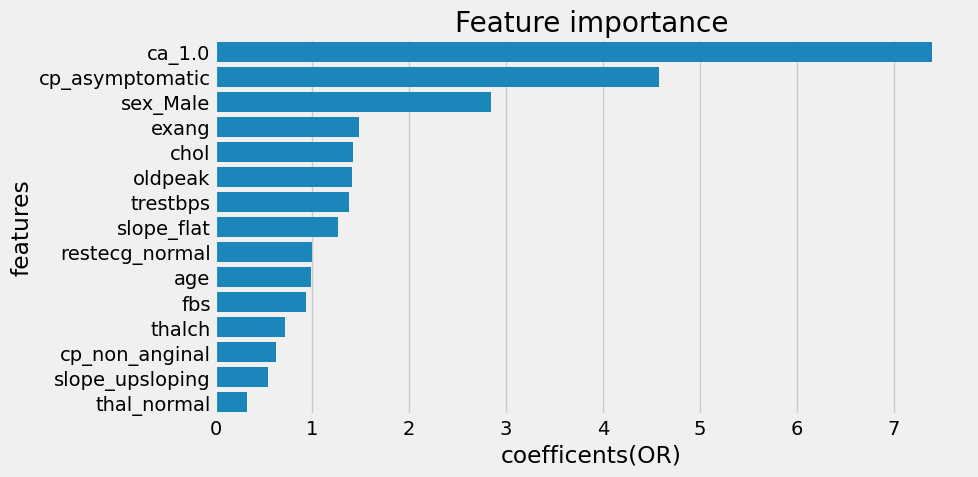

In [25]:
# Visualize feature importance
fig = plt.figure(figsize=(10,5))
sns.barplot(x="coefficents(OR)", y="features", data=df_importance)
plt.title("Feature importance")

dm.save_fig(fig_id="feature_importance", image_directory=Path("outputs"))

### Comments

- Clinical data plays an important role in predicting heart diease. This suggest that we can partner with health care providers and pathology labs to obtain more data. However, an implication is that patients who delay in care-seeking might be at risk of delayed diagnosis and treatment. Demographics plays an important role: Male are 2.8 times more likely to suffer from heart disease than their female counterpart.

    - Patients with 1 or more major vessels colored by fluoroscopy are 7 times more likely to have heart disease than their counterparts with no major vessels colored.
    - Worryingly, patients with asymptomatic chest pain (absence of classical acute coronary syndrome (ACS) pain) are 4.5 times more likely to have heart disease than those with typical angina chest pain. Beacuse it's not immediately noticebale, heart disease patients with asymptomatic chest pains may face delayed diagnosis and treatment.
    - `exang` (exercise induced angina) is a metric that is only measureable at the clinic: patients with exercise induced angina are 1.48 times more likely to have heart disease than those without.
    - thal stress tests is also predictive of heart disease: those with normal test results are only a third as likely to have heart disease than those with abnormal results.
    - Patients with upsloping ST segment are half as likely to have heart disease than those with downsloping ST segment.

 


### Confusion Matrix

In [27]:
y_pred = best_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[27  5]
 [ 5 24]]


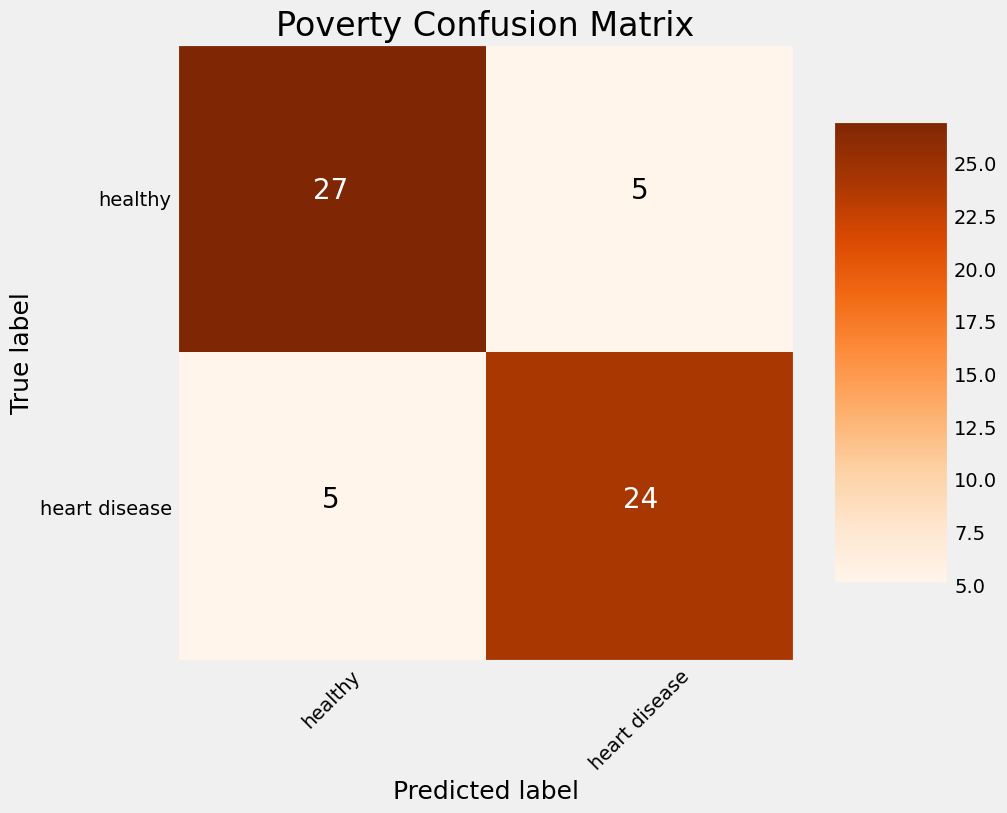

In [28]:
utils.plot_confusion_matrix(cm = cm, 
                      classes = ['healthy', 'heart disease'],
                      normalize=False,
                      title = 'Poverty Confusion Matrix')

In [29]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.83      0.83      0.83        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



### ROC AUC curve

In [30]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [31]:
y_train_pred_scores = cross_val_predict(
    estimator = best_pipeline,
    X = X_train,
    y = y_train,
    cv = kf,
    method = "predict_proba"
)

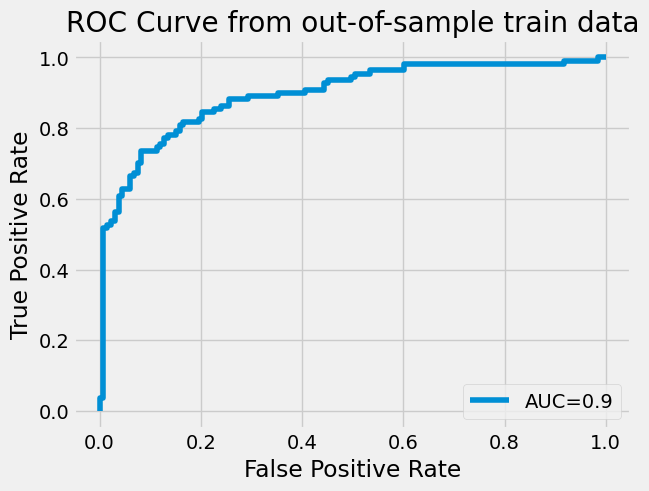

In [32]:
fpr, tpr, _ = roc_curve(y_train,  y_train_pred_scores[:,1])
roc_auc = round(roc_auc_score(y_train, y_train_pred_scores[:,1]),2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve from out-of-sample train data')
plt.legend(loc=4)
plt.show()

**Test ROC_AUC**

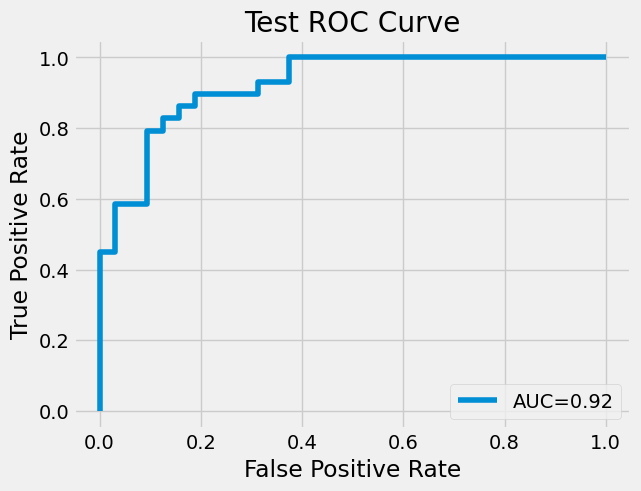

In [33]:
y_pred_proba = best_pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
test_roc_auc = round(roc_auc_score(y_test, y_pred_proba),2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(test_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc=4)
plt.show()

### Conclusion

- We were able to predict heart disease with 15 features using a simple, and interpretible logisitc regression model with high performance (test roc_auc >0.9)
- The most important predictors are clinical data that are obtainable from pathology labs and health care providers. This suggest that we can partner with these entities to obtain more data. Demographics also plays a role as male is substantially more likely to have heart disease than their female counterparts. Additional demographics characteristics could be collected from patients.
- With a larger serving data, the model can be used to generate mean predicted probabilities of heart disease in a geographic area (e.g., HSA or census tract). This allow us to gauge the demand for Pfizer's products such as Vyndaqel and Vyndamax in specific geographic areas, which in turn inform the company's production and distribution plans, as well as marketing strategies at a more precise level. 